In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directories
output_dir = "output"
model_dir = os.path.join(output_dir, 'models')
results_dir = os.path.join(output_dir, 'results')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

Using device: cuda


In [2]:
class MaskedHyperspectralDataset(Dataset):
    def __init__(self, pickle_file, patch_size=None):
        """
        Dataset for hyperspectral data with mask handling

        Args:
            pickle_file: Path to pickle file
            patch_size: Size of patches to extract (None for full image)
        """
        self.pickle_file = Path(pickle_file)
        self.patch_size = patch_size

        # Load the data
        print(f"Loading data from {self.pickle_file}...")
        with open(self.pickle_file, 'rb') as f:
            self.data_dict = pickle.load(f)

        # Get dimensions
        self.excitation_wavelengths = sorted([float(ex) for ex in self.data_dict['data'].keys()])
        print(f"Found {len(self.excitation_wavelengths)} excitation wavelengths")

        # Get dimensions from first excitation
        first_ex = str(self.excitation_wavelengths[0])
        self.height, self.width, _ = self.data_dict['data'][first_ex]['cube'].shape
        print(f"Image dimensions: {self.height} x {self.width}")

        # Create data and mask tensors
        self._create_data_and_mask()

        # Setup patches if needed
        if patch_size is not None:
            self._setup_patches()

    def _create_data_and_mask(self):
        """Create data tensor and corresponding mask"""
        # Find maximum number of emission bands across all excitations
        self.n_excitations = len(self.excitation_wavelengths)
        self.max_emissions = max(len(self.data_dict['data'][str(ex)]['wavelengths'])
                                for ex in self.excitation_wavelengths)
        print(f"Maximum emission bands: {self.max_emissions}")

        # Create tensors
        self.data_tensor = np.zeros((self.n_excitations, self.max_emissions, self.height, self.width))
        self.mask_tensor = np.zeros((self.n_excitations, self.max_emissions, self.height, self.width), dtype=bool)
        self.wavelength_info = []

        # Fill tensors
        for ex_idx, ex in enumerate(self.excitation_wavelengths):
            ex_str = str(ex)
            cube = self.data_dict['data'][ex_str]['cube']
            wavelengths = self.data_dict['data'][ex_str]['wavelengths']
            self.wavelength_info.append(wavelengths)

            # Transpose to [emissions, height, width]
            transposed_cube = np.transpose(cube, (2, 0, 1))

            # Fill data and mask
            n_em = len(wavelengths)
            self.data_tensor[ex_idx, :n_em, :, :] = transposed_cube
            self.mask_tensor[ex_idx, :n_em, :, :] = ~np.isnan(transposed_cube)

        # Replace NaNs with zeros for convenience
        self.data_tensor = np.nan_to_num(self.data_tensor, nan=0.0)

        # Report mask statistics
        valid_percentage = self.mask_tensor.sum() / self.mask_tensor.size * 100
        print(f"Valid data percentage: {valid_percentage:.2f}%")

    def _setup_patches(self):
        """Setup patches for extraction"""
        # Calculate number of patches
        patches_y = max(1, (self.height - self.patch_size) // (self.patch_size // 2) + 1)
        patches_x = max(1, (self.width - self.patch_size) // (self.patch_size // 2) + 1)

        # Generate patch positions (with 50% overlap)
        self.patch_positions = []
        for i in range(patches_y):
            y = min(i * (self.patch_size // 2), self.height - self.patch_size)
            for j in range(patches_x):
                x = min(j * (self.patch_size // 2), self.width - self.patch_size)
                # Only add patches with some valid data
                patch_mask = self.mask_tensor[:, :, y:y+self.patch_size, x:x+self.patch_size]
                if patch_mask.sum() > 0:  # At least one valid point
                    self.patch_positions.append((y, x))

        print(f"Created {len(self.patch_positions)} valid patches of size {self.patch_size}x{self.patch_size}")

    def __len__(self):
        """Return dataset length"""
        return len(self.patch_positions) if self.patch_size is not None else 1

    def __getitem__(self, idx):
        """Get data with mask"""
        if self.patch_size is not None:
            # Extract patch
            y, x = self.patch_positions[idx]
            data = self.data_tensor[:, :, y:y+self.patch_size, x:x+self.patch_size].copy()
            mask = self.mask_tensor[:, :, y:y+self.patch_size, x:x+self.patch_size].copy()
            positions = (y, x)
        else:
            # Return full tensor
            data = self.data_tensor.copy()
            mask = self.mask_tensor.copy()
            positions = (0, 0)

        # Convert to tensors
        data_tensor = torch.tensor(data, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)  # Convert bool to float for math operations
        pos_tensor = torch.tensor(positions, dtype=torch.long)

        return {
            'data': data_tensor,
            'mask': mask_tensor,
            'positions': pos_tensor
        }

In [3]:
class ConvBlock(nn.Module):
    """Basic convolutional block with batch normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class UpConvBlock(nn.Module):
    """Upsampling block for decoder"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = ConvBlock(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        return self.conv(self.upsample(x))

class MaskedHyperspectralAutoencoder(nn.Module):
    """
    Autoencoder for hyperspectral data with mask handling
    """
    def __init__(self, n_excitations, n_emissions, patch_size=64, latent_dim=128, n_clusters=5):
        super().__init__()

        self.n_excitations = n_excitations
        self.n_emissions = n_emissions
        self.patch_size = patch_size
        self.latent_dim = latent_dim
        self.n_clusters = n_clusters

        # Number of channels when flattening excitation-emission dims
        self.n_channels = n_excitations * n_emissions

        # Encoder pathway
        self.encoder = nn.Sequential(
            # First layer: [batch, n_channels, patch_size, patch_size]
            ConvBlock(self.n_channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second layer: [batch, 64, patch_size/2, patch_size/2]
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third layer: [batch, 128, patch_size/4, patch_size/4]
            ConvBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate size after encoding
        self.encoded_size = patch_size // 8

        # Latent representation
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(256 * self.encoded_size * self.encoded_size, latent_dim)

        # Clustering head
        self.cluster_head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_clusters)
        )

        # Decoder pathway
        self.fc_decode = nn.Linear(latent_dim, 256 * self.encoded_size * self.encoded_size)
        self.unflatten = nn.Unflatten(1, (256, self.encoded_size, self.encoded_size))

        self.decoder = nn.Sequential(
            # First decoder layer: [batch, 256, patch_size/8, patch_size/8]
            UpConvBlock(256, 128, scale_factor=2),

            # Second decoder layer: [batch, 128, patch_size/4, patch_size/4]
            UpConvBlock(128, 64, scale_factor=2),

            # Final decoder layer: [batch, 64, patch_size/2, patch_size/2]
            UpConvBlock(64, self.n_channels, scale_factor=2),

            # Output activation
            nn.Sigmoid()  # Normalize output to [0,1]
        )

    def forward(self, x, mask=None):
        """
        Forward pass through the autoencoder

        Args:
            x: Input tensor [batch, n_excitations, n_emissions, patch_size, patch_size]
            mask: Mask tensor [batch, n_excitations, n_emissions, patch_size, patch_size]

        Returns:
            reconstructed: Reconstructed data
            latent: Latent features
            cluster_logits: Clustering logits
        """
        batch_size = x.shape[0]

        # Store original shape
        original_shape = x.shape

        # Reshape to merge excitation and emission dimensions
        x_reshaped = x.reshape(batch_size, self.n_channels, original_shape[3], original_shape[4])

        # Encode
        encoded = self.encoder(x_reshaped)

        # Compress to latent space
        flattened = self.flatten(encoded)
        latent = self.fc_encode(flattened)

        # Prevent NaN values
        if torch.isnan(latent).any():
            print("Warning: NaN in latent space - replacing with zeros")
            latent = torch.nan_to_num(latent, nan=0.0)

        # Get cluster assignments
        cluster_logits = self.cluster_head(latent)

        # Decode from latent space
        decoded_flat = self.fc_decode(latent)
        decoded_3d = self.unflatten(decoded_flat)

        # Reconstruct
        reconstructed_flat = self.decoder(decoded_3d)

        # Reshape back to original dimensions
        reconstructed = reconstructed_flat.reshape(
            batch_size,
            original_shape[1],  # n_excitations
            original_shape[2],  # n_emissions
            original_shape[3],  # patch_size/height
            original_shape[4]   # patch_size/width
        )

        # Zero out invalid regions in reconstruction (optional)
        if mask is not None:
            reconstructed = reconstructed * mask

        return reconstructed, latent, cluster_logits

In [4]:
class ConvBlock(nn.Module):
    """Basic convolutional block with batch normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class UpConvBlock(nn.Module):
    """Upsampling block for decoder"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = ConvBlock(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        return self.conv(self.upsample(x))

class MaskedHyperspectralAutoencoder(nn.Module):
    """
    Autoencoder for hyperspectral data with mask handling
    """
    def __init__(self, n_excitations, n_emissions, patch_size=64, latent_dim=128, n_clusters=5):
        super().__init__()

        self.n_excitations = n_excitations
        self.n_emissions = n_emissions
        self.patch_size = patch_size
        self.latent_dim = latent_dim
        self.n_clusters = n_clusters

        # Number of channels when flattening excitation-emission dims
        self.n_channels = n_excitations * n_emissions

        # Encoder pathway
        self.encoder = nn.Sequential(
            # First layer: [batch, n_channels, patch_size, patch_size]
            ConvBlock(self.n_channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second layer: [batch, 64, patch_size/2, patch_size/2]
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third layer: [batch, 128, patch_size/4, patch_size/4]
            ConvBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate size after encoding
        self.encoded_size = patch_size // 8

        # Latent representation
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(256 * self.encoded_size * self.encoded_size, latent_dim)

        # Clustering head
        self.cluster_head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_clusters)
        )

        # Decoder pathway
        self.fc_decode = nn.Linear(latent_dim, 256 * self.encoded_size * self.encoded_size)
        self.unflatten = nn.Unflatten(1, (256, self.encoded_size, self.encoded_size))

        self.decoder = nn.Sequential(
            # First decoder layer: [batch, 256, patch_size/8, patch_size/8]
            UpConvBlock(256, 128, scale_factor=2),

            # Second decoder layer: [batch, 128, patch_size/4, patch_size/4]
            UpConvBlock(128, 64, scale_factor=2),

            # Final decoder layer: [batch, 64, patch_size/2, patch_size/2]
            UpConvBlock(64, self.n_channels, scale_factor=2),

            # Output activation
            nn.Sigmoid()  # Normalize output to [0,1]
        )

    def forward(self, x, mask=None):
        """
        Forward pass through the autoencoder

        Args:
            x: Input tensor [batch, n_excitations, n_emissions, patch_size, patch_size]
            mask: Mask tensor [batch, n_excitations, n_emissions, patch_size, patch_size]

        Returns:
            reconstructed: Reconstructed data
            latent: Latent features
            cluster_logits: Clustering logits
        """
        batch_size = x.shape[0]

        # Store original shape
        original_shape = x.shape

        # Reshape to merge excitation and emission dimensions
        x_reshaped = x.reshape(batch_size, self.n_channels, original_shape[3], original_shape[4])

        # Encode
        encoded = self.encoder(x_reshaped)

        # Compress to latent space
        flattened = self.flatten(encoded)
        latent = self.fc_encode(flattened)

        # Prevent NaN values
        if torch.isnan(latent).any():
            print("Warning: NaN in latent space - replacing with zeros")
            latent = torch.nan_to_num(latent, nan=0.0)

        # Get cluster assignments
        cluster_logits = self.cluster_head(latent)

        # Decode from latent space
        decoded_flat = self.fc_decode(latent)
        decoded_3d = self.unflatten(decoded_flat)

        # Reconstruct
        reconstructed_flat = self.decoder(decoded_3d)

        # Reshape back to original dimensions
        reconstructed = reconstructed_flat.reshape(
            batch_size,
            original_shape[1],  # n_excitations
            original_shape[2],  # n_emissions
            original_shape[3],  # patch_size/height
            original_shape[4]   # patch_size/width
        )

        # Zero out invalid regions in reconstruction (optional)
        if mask is not None:
            reconstructed = reconstructed * mask

        return reconstructed, latent, cluster_logits

In [5]:
class MaskedMSELoss(nn.Module):
    """MSE loss that only considers masked (valid) values"""
    def __init__(self):
        super().__init__()

    def forward(self, pred, target, mask):
        """
        Compute MSE only on valid values

        Args:
            pred: Predicted values [batch, channels, height, width]
            target: Target values  [batch, channels, height, width]
            mask: Binary mask [batch, channels, height, width] (1 for valid)

        Returns:
            Masked MSE loss
        """
        # Element-wise squared error
        squared_diff = (pred - target) ** 2

        # Apply mask
        masked_squared_diff = squared_diff * mask

        # Sum and normalize by number of valid elements
        valid_elements = mask.sum() + 1e-8  # Avoid division by zero
        loss = masked_squared_diff.sum() / valid_elements

        return loss

class MaskedDeepClusteringLoss(nn.Module):
    """
    Combined loss function for masked deep clustering with reconstruction
    """
    def __init__(self, n_clusters, alpha=1.0, beta=0.1, gamma=0.01):
        super().__init__()
        self.n_clusters = n_clusters

        # Loss weights
        self.alpha = alpha  # Reconstruction weight
        self.beta = beta    # Clustering weight
        self.gamma = gamma  # Regularization weight

        # MSE loss for reconstruction
        self.mse_loss = MaskedMSELoss()

        # K-means state
        self.kmeans = None
        self.centroids = None
        self.initialized = False

    def forward(self, original, reconstructed, latent_features, mask, target_distribution=None):
        """
        Compute the combined loss

        Args:
            original: Original input data
            reconstructed: Reconstructed data
            latent_features: Latent space features
            mask: Binary mask of valid values
            target_distribution: Optional target distribution

        Returns:
            total_loss, recon_loss, cluster_loss, reg_loss
        """
        # Reconstruction loss (masked MSE)
        recon_loss = self.mse_loss(reconstructed, original, mask)

        # Initialize or update centroids
        if not self.initialized or self.centroids is None:
            # Get features as numpy
            features_np = latent_features.detach().cpu().numpy()

            # Check for NaN values
            if np.isnan(features_np).any():
                print(f"Warning: Found {np.isnan(features_np).sum()} NaN values in features")
                features_np = np.nan_to_num(features_np, nan=0.0)

            # Initialize k-means
            try:
                self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
                self.kmeans.fit(features_np)

                # Convert centroids to tensor
                self.centroids = torch.tensor(
                    self.kmeans.cluster_centers_,
                    dtype=torch.float,
                    device=latent_features.device
                )

                self.initialized = True
            except Exception as e:
                print(f"Error initializing KMeans: {e}")
                # Fallback: random centroids
                print("Using random centroids as fallback")
                self.centroids = torch.randn(
                    self.n_clusters, latent_features.shape[1],
                    device=latent_features.device
                )
                self.initialized = True

        # Compute distances to centroids
        distances = torch.cdist(latent_features, self.centroids)

        # Convert distances to probabilities
        q = 1.0 / (1.0 + distances ** 2)
        q = q / q.sum(dim=1, keepdim=True)

        # Clustering loss
        if target_distribution is not None:
            # KL divergence
            cluster_loss = F.kl_div(q.log(), target_distribution, reduction='batchmean')
        else:
            # Basic clustering loss
            min_distances = torch.min(distances, dim=1)[0]
            cluster_loss = torch.mean(min_distances)

        # Regularization
        feature_var = torch.var(latent_features, dim=0).mean()
        reg_loss = 1.0 / (feature_var + 1e-6)

        # Combined loss
        total_loss = (
            self.alpha * recon_loss +
            self.beta * cluster_loss +
            self.gamma * reg_loss
        )

        return total_loss, recon_loss, cluster_loss, reg_loss

    def update_centroids(self, latent_features):
        """Update centroids with current batch features"""
        # Get features
        features_np = latent_features.detach().cpu().numpy()
        features_np = np.nan_to_num(features_np, nan=0.0)

        # Update centroids
        try:
            self.kmeans.fit(features_np)
            self.centroids = torch.tensor(
                self.kmeans.cluster_centers_,
                dtype=torch.float,
                device=latent_features.device
            )
        except Exception as e:
            print(f"Error updating centroids: {e}")

        return self.centroids

In [6]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

def train_masked_autoencoder(model, train_loader, val_loader=None,
                           n_epochs=100, n_clusters=5,
                           learning_rate=0.001, device='cuda',
                           model_save_path='models',
                           update_interval=5,
                           patience=10):
    """
    Train the masked autoencoder

    Args:
        model: Autoencoder model
        train_loader: Training data loader
        val_loader: Validation data loader (optional)
        n_epochs: Number of epochs
        n_clusters: Number of clusters
        learning_rate: Learning rate
        device: Device to use
        model_save_path: Path to save model
        update_interval: Update clusters every N epochs
        patience: Early stopping patience

    Returns:
        Trained model and history
    """
    # Set device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Define criterion and optimizer
    criterion = MaskedDeepClusteringLoss(n_clusters=n_clusters, alpha=1.0, beta=0.1, gamma=0.01)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    # Early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Create save directory
    os.makedirs(model_save_path, exist_ok=True)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'recon_loss': [],
        'cluster_loss': [],
        'reg_loss': []
    }

    # Track best validation loss
    best_val_loss = float('inf')

    # Training loop
    start_time = time.time()
    print(f"Starting training for {n_epochs} epochs...")

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        recon_loss_sum = 0.0
        cluster_loss_sum = 0.0
        reg_loss_sum = 0.0
        batch_count = 0

        # Training
        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            data = batch['data'].to(device)
            mask = batch['mask'].to(device)

            # Forward pass
            reconstructed, latent, _ = model(data, mask)

            # Compute loss
            loss, recon_loss, cluster_loss, reg_loss = criterion(
                data, reconstructed, latent, mask
            )

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update statistics
            batch_count += 1
            total_loss += loss.item()
            recon_loss_sum += recon_loss.item()
            cluster_loss_sum += cluster_loss.item()
            reg_loss_sum += reg_loss.item()

            # Print progress
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, "
                      f"Loss: {loss.item():.6f}, Recon: {recon_loss.item():.6f}, "
                      f"Cluster: {cluster_loss.item():.6f}, Reg: {reg_loss.item():.6f}")

        # Update centroids periodically
        if epoch % update_interval == 0 and epoch > 0:
            # Collect all latent representations
            all_features = []
            model.eval()
            with torch.no_grad():
                for batch in train_loader:
                    data = batch['data'].to(device)
                    mask = batch['mask'].to(device)
                    _, latent, _ = model(data, mask)
                    all_features.append(latent)

            if all_features:
                all_features = torch.cat(all_features, dim=0)
                criterion.update_centroids(all_features)

        # Compute epoch averages
        avg_loss = total_loss / batch_count
        avg_recon_loss = recon_loss_sum / batch_count
        avg_cluster_loss = cluster_loss_sum / batch_count
        avg_reg_loss = reg_loss_sum / batch_count

        # Validation
        val_loss = 0.0
        if val_loader is not None:
            model.eval()
            val_batches = 0

            with torch.no_grad():
                for batch in val_loader:
                    data = batch['data'].to(device)
                    mask = batch['mask'].to(device)

                    # Forward pass
                    reconstructed, latent, _ = model(data, mask)

                    # Compute reconstruction loss only for validation
                    mse_criterion = MaskedMSELoss()
                    loss = mse_criterion(reconstructed, data, mask)

                    val_loss += loss.item()
                    val_batches += 1

            if val_batches > 0:
                val_loss /= val_batches

                # Update learning rate
                scheduler.step(val_loss)

                # Early stopping
                early_stopping(val_loss)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), os.path.join(model_save_path, 'best_model.pt'))
                    print(f"Saved best model with validation loss: {val_loss:.6f}")

                if early_stopping.early_stop:
                    print("Early stopping triggered!")
                    break

        # Store history
        history['train_loss'].append(avg_loss)
        history['val_loss'].append(val_loss if val_loader is not None else None)
        history['recon_loss'].append(avg_recon_loss)
        history['cluster_loss'].append(avg_cluster_loss)
        history['reg_loss'].append(avg_reg_loss)

        # Print epoch summary
        elapsed = time.time() - start_time
        print(f'Epoch {epoch+1}/{n_epochs}, Time: {elapsed:.2f}s, '
              f'Loss: {avg_loss:.6f}, '
              f'Recon: {avg_recon_loss:.6f}, '
              f'Cluster: {avg_cluster_loss:.6f}, '
              f'Reg: {avg_reg_loss:.6f}' +
              (f', Val Loss: {val_loss:.6f}' if val_loader is not None else ''))

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'history': history
            }, os.path.join(model_save_path, f'checkpoint_{epoch+1}.pt'))

    # Save final model
    torch.save(model.state_dict(), os.path.join(model_save_path, 'final_model.pt'))

    # Save history
    np.save(os.path.join(model_save_path, 'training_history.npy'), history)

    # Load best model if validation was used
    if val_loader is not None:
        model.load_state_dict(torch.load(os.path.join(model_save_path, 'best_model.pt')))

    return model, history

In [7]:
# Set data path to your pickle file
data_path = "../Data/Kiwi Experiment/pickles/masked_KiwiData.pkl"

# Create dataset with patches
patch_size = 64  # Can adjust based on your data/memory
dataset = MaskedHyperspectralDataset(
    pickle_file=data_path,
    patch_size=patch_size
)

# Check sample data to verify mask
sample = dataset[0]
print(f"Sample data shape: {sample['data'].shape}")
print(f"Sample mask shape: {sample['mask'].shape}")
print(f"Valid data percentage in sample: {sample['mask'].sum().item() / sample['mask'].numel() * 100:.2f}%")

# Split dataset into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
batch_size = 8  # Adjust based on your GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

Loading data from ..\Data\Kiwi Experiment\pickles\masked_KiwiData.pkl...
Found 21 excitation wavelengths
Image dimensions: 1024 x 1392
Maximum emission bands: 31
Valid data percentage: 71.45%
Created 1208 valid patches of size 64x64
Sample data shape: torch.Size([21, 31, 64, 64])
Sample mask shape: torch.Size([21, 31, 64, 64])
Valid data percentage in sample: 0.95%
Training samples: 966
Validation samples: 242


In [8]:
# Create model
n_excitations = dataset.n_excitations
n_emissions = dataset.max_emissions
n_clusters = 5  # Start with fewer clusters for stability

model = MaskedHyperspectralAutoencoder(
    n_excitations=n_excitations,
    n_emissions=n_emissions,
    patch_size=patch_size,
    latent_dim=64,  # Lower dimension for start
    n_clusters=n_clusters
)
model = model.to(device)
# Print model summary
print(f"Created autoencoder with:")
print(f"  {n_excitations} excitation wavelengths")
print(f"  {n_emissions} emission bands")
print(f"  {n_clusters} clusters")
print(f"  {patch_size}x{patch_size} patch size")
print(f"  {sum(p.numel() for p in model.parameters()):,} total parameters")

# Test forward pass with a sample
with torch.no_grad():
    sample = next(iter(train_loader))
    data = sample['data'].to(device)
    mask = sample['mask'].to(device)

    # Forward pass
    try:
        reconstructed, latent, cluster_logits = model(data, mask)
        print(f"Forward pass successful!")
        print(f"Input shape: {data.shape}")
        print(f"Mask shape: {mask.shape}")
        print(f"Reconstruction shape: {reconstructed.shape}")
        print(f"Latent shape: {latent.shape}")
        print(f"Cluster logits shape: {cluster_logits.shape}")
    except Exception as e:
        print(f"Error in forward pass: {e}")

Created autoencoder with:
  21 excitation wavelengths
  31 emission bands
  5 clusters
  64x64 patch size
  3,609,190 total parameters
Forward pass successful!
Input shape: torch.Size([8, 21, 31, 64, 64])
Mask shape: torch.Size([8, 21, 31, 64, 64])
Reconstruction shape: torch.Size([8, 21, 31, 64, 64])
Latent shape: torch.Size([8, 64])
Cluster logits shape: torch.Size([8, 5])


C:\Users\meloy\PycharmProjects\Capstone\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for 10 epochs...
Epoch 1/10, Batch 0, Loss: 85757.992188, Recon: 85757.882812, Cluster: 0.728001, Reg: 4.015936
Epoch 1/10, Batch 10, Loss: 167573.781250, Recon: 167572.859375, Cluster: 9.238847, Reg: 0.732744
Epoch 1/10, Batch 20, Loss: 103392.750000, Recon: 103391.835938, Cluster: 9.024302, Reg: 0.650357
Epoch 1/10, Batch 30, Loss: 172101.578125, Recon: 172100.609375, Cluster: 9.709249, Reg: 0.442032
Epoch 1/10, Batch 40, Loss: 162858.453125, Recon: 162857.390625, Cluster: 10.584797, Reg: 0.400589
Epoch 1/10, Batch 50, Loss: 54739.234375, Recon: 54738.402344, Cluster: 8.240197, Reg: 0.764963
Epoch 1/10, Batch 60, Loss: 121013.875000, Recon: 121012.906250, Cluster: 9.658972, Reg: 0.281870
Epoch 1/10, Batch 70, Loss: 171268.968750, Recon: 171268.281250, Cluster: 6.766554, Reg: 1.021378
Epoch 1/10, Batch 80, Loss: 116338.625000, Recon: 116337.640625, Cluster: 9.732710, Reg: 0.434297
Epoch 1/10, Batch 90, Loss: 154121.453125, Recon: 154120.703125, Cluster: 7.528508, Reg

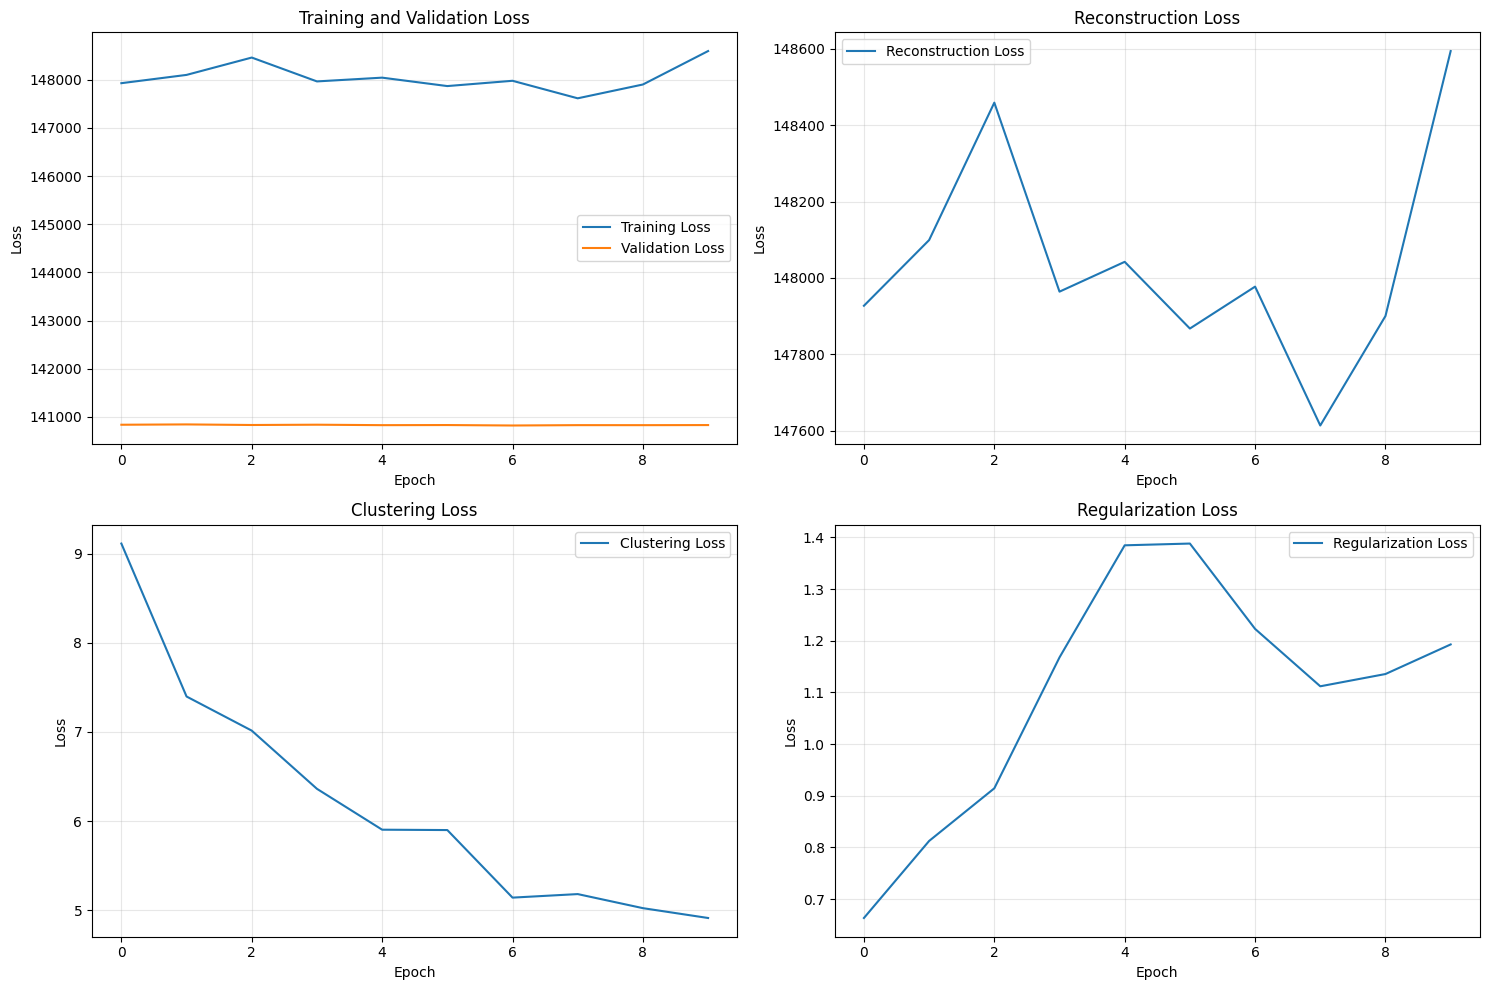

In [9]:
# Training parameters
epochs = 10  # Can increase for better results
learning_rate = 0.0001  # Lower learning rate for stability
update_interval = 5  # Update cluster centroids every 5 epochs
patience = 15  # Early stopping patience

# Train model
model, history = train_masked_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=epochs,
    n_clusters=n_clusters,
    learning_rate=learning_rate,
    device=device,
    model_save_path=model_dir,
    update_interval=update_interval,
    patience=patience
)

# Plot training history
plt.figure(figsize=(15, 10))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
if history['val_loss'][0] is not None:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot reconstruction loss
plt.subplot(2, 2, 2)
plt.plot(history['recon_loss'], label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot clustering loss
plt.subplot(2, 2, 3)
plt.plot(history['cluster_loss'], label='Clustering Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Clustering Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot regularization loss
plt.subplot(2, 2, 4)
plt.plot(history['reg_loss'], label='Regularization Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Regularization Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

Loading data from ..\Data\Kiwi Experiment\pickles\masked_KiwiData.pkl...
Found 21 excitation wavelengths
Image dimensions: 1024 x 1392
Maximum emission bands: 31
Valid data percentage: 71.45%
Created 1208 valid patches of size 64x64
Processed 0/1208 patches
Processed 100/1208 patches
Processed 200/1208 patches
Processed 300/1208 patches
Processed 400/1208 patches
Processed 500/1208 patches
Processed 600/1208 patches
Processed 700/1208 patches
Processed 800/1208 patches
Processed 900/1208 patches
Processed 1000/1208 patches
Processed 1100/1208 patches
Processed 1200/1208 patches


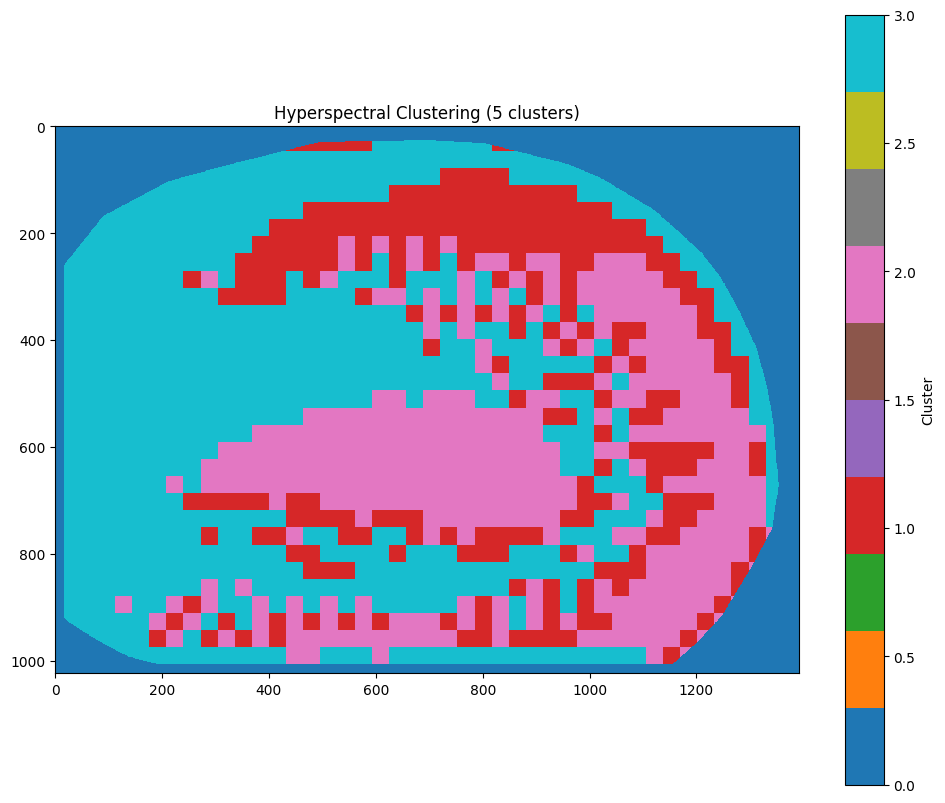

In [10]:
# Create a dataset for patch-based processing of the full image
# (Keep using patches, but reconstruct the full image from patches)
full_dataset = MaskedHyperspectralDataset(
    pickle_file=data_path,
    patch_size=patch_size  # Keep using the same patch size
)

# Create a label grid to store the results
height, width = full_dataset.height, full_dataset.width
label_grid = np.zeros((height, width), dtype=int)
confidence_grid = np.zeros((height, width), dtype=float)

# Process each patch
model.eval()
with torch.no_grad():
    for idx in range(len(full_dataset)):
        batch = full_dataset[idx]
        data = batch['data'].unsqueeze(0).to(device)  # Add batch dimension
        mask = batch['mask'].unsqueeze(0).to(device)
        positions = batch['positions']
        y, x = positions.numpy()

        # Forward pass
        _, latent, cluster_logits = model(data, mask)

        # Get cluster predictions
        probs = F.softmax(cluster_logits, dim=1)
        confidence, predictions = torch.max(probs, dim=1)

        # Extract patch predictions
        pred_cluster = predictions[0].item()
        pred_confidence = confidence[0].item()

        # Fill in the label grid with this patch's prediction
        # Take a portion of the patch (center region) to avoid overlap issues
        center_size = patch_size // 2
        center_offset = patch_size // 4

        y_start = min(y + center_offset, height - center_size)
        x_start = min(x + center_offset, width - center_size)
        y_end = min(y_start + center_size, height)
        x_end = min(x_start + center_size, width)

        # Only update if the confidence is higher than what's already there
        for yi in range(y_start, y_end):
            for xi in range(x_start, x_end):
                if mask[0, :, :, yi-y, xi-x].any() and pred_confidence > confidence_grid[yi, xi]:
                    label_grid[yi, xi] = pred_cluster
                    confidence_grid[yi, xi] = pred_confidence

        # Print progress
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(full_dataset)} patches")

# Visualize clusters
plt.figure(figsize=(12, 10))
plt.imshow(label_grid, cmap='tab10', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title(f'Hyperspectral Clustering ({n_clusters} clusters)')
plt.savefig(os.path.join(results_dir, 'cluster_map.png'), dpi=300, bbox_inches='tight')
plt.show()

mask_grid = confidence_grid > 0


Cluster Statistics:

Cluster    Pixels     Percentage      Notable Peaks
----------------------------------------------------------------------
0          267215     23.07%           Ex:500/Em:520, Ex:490/Em:510
1          252940     21.84%           Ex:500/Em:520, Ex:490/Em:510
2          342922     29.61%           Ex:500/Em:520, Ex:490/Em:510
3          562331     48.55%           Ex:500/Em:520, Ex:490/Em:510


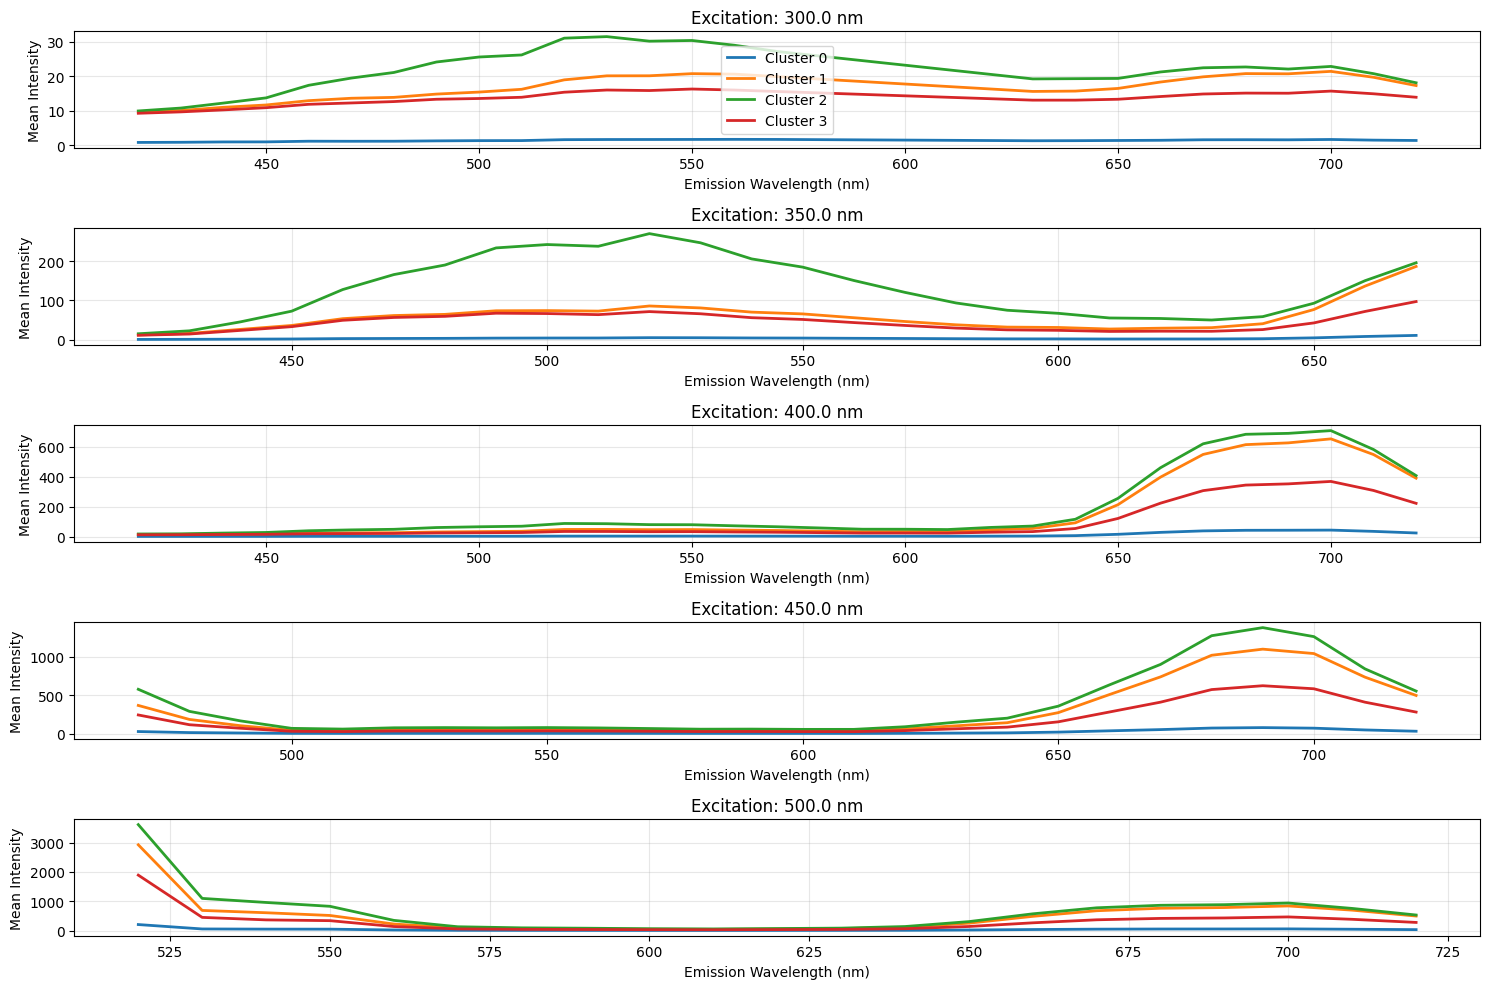

In [11]:
# Analyze spectral characteristics of each cluster
cluster_stats = {}

# Get excitation and emission wavelengths
ex_wavelengths = dataset.excitation_wavelengths
em_wavelengths = dataset.wavelength_info  # List of wavelength lists for each excitation

# For each cluster, analyze spectral signature
for cluster_idx in range(n_clusters):
    # Get mask for this cluster
    cluster_mask = label_grid == cluster_idx

    # Skip if cluster is empty
    if not np.any(cluster_mask):
        continue

    # Get pixel count and percentage
    pixel_count = np.sum(cluster_mask)
    percentage = pixel_count / np.sum(mask_grid) * 100

    # Store basic stats
    cluster_stats[cluster_idx] = {
        'pixel_count': pixel_count,
        'percentage': percentage,
        'spectra': {}
    }

    # Get mean spectrum for each excitation
    for ex_idx, ex in enumerate(ex_wavelengths):
        # Get wavelengths for this excitation
        wavelengths = em_wavelengths[ex_idx]

        # Get data for this excitation
        ex_data = full_dataset.data_tensor[ex_idx, :len(wavelengths)]

        # Extract data for cluster pixels
        cluster_data = ex_data[:, cluster_mask]

        # Calculate mean spectrum
        if cluster_data.size > 0:
            mean_spectrum = np.mean(cluster_data, axis=1)

            # Find peak wavelength and value
            peak_idx = np.argmax(mean_spectrum)
            if peak_idx < len(wavelengths):
                peak_wavelength = wavelengths[peak_idx]
                peak_value = mean_spectrum[peak_idx]
            else:
                peak_wavelength = None
                peak_value = None

            # Store spectral data
            cluster_stats[cluster_idx]['spectra'][ex] = {
                'wavelengths': wavelengths,
                'mean_spectrum': mean_spectrum,
                'peak_wavelength': peak_wavelength,
                'peak_value': peak_value
            }

# Print summary
print("\nCluster Statistics:\n")
print(f"{'Cluster':<10} {'Pixels':<10} {'Percentage':<15} {'Notable Peaks'}")
print("-" * 70)

for cluster_idx, stats in cluster_stats.items():
    # Get top peaks
    peak_info = []
    for ex, ex_data in stats['spectra'].items():
        if ex_data['peak_wavelength'] is not None:
            peak_info.append((ex, ex_data['peak_wavelength'], ex_data['peak_value']))

    # Sort by intensity
    peak_info.sort(key=lambda x: x[2] if x[2] is not None else 0, reverse=True)

    # Format peak info text
    peak_text = ", ".join(f"Ex:{ex:.0f}/Em:{em:.0f}" for ex, em, _ in peak_info[:2])

    print(f"{cluster_idx:<10} {stats['pixel_count']:<10} {stats['percentage']:.2f}%{' ':<10} {peak_text}")

# Plot spectral signatures by cluster
plt.figure(figsize=(15, 10))

# Sample a few excitation wavelengths to plot
plot_ex_indices = np.linspace(0, len(ex_wavelengths)-1, min(5, len(ex_wavelengths)), dtype=int)

for i, ex_idx in enumerate(plot_ex_indices):
    ex = ex_wavelengths[ex_idx]
    wavelengths = em_wavelengths[ex_idx]

    plt.subplot(len(plot_ex_indices), 1, i+1)

    for cluster_idx, stats in cluster_stats.items():
        if ex in stats['spectra']:
            spectrum = stats['spectra'][ex]['mean_spectrum']
            plt.plot(wavelengths, spectrum, '-', linewidth=2, label=f'Cluster {cluster_idx}')

    plt.xlabel('Emission Wavelength (nm)')
    plt.ylabel('Mean Intensity')
    plt.title(f'Excitation: {ex} nm')
    plt.grid(True, alpha=0.3)

    if i == 0:  # Only add legend to first plot
        plt.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'spectral_signatures.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save cluster stats
with open(os.path.join(results_dir, 'cluster_stats.pkl'), 'wb') as f:
    pickle.dump(cluster_stats, f)